In [402]:
import pandas as pd
import numpy as np
import kaggle
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot

In [18]:
data = pd.read_csv('/Users/simonlipson/Downloads/aflstats/stats.csv')

In [3]:
data.head()

,Team,Player,D.O.B,Height,Weight,Position,Season,Round,Date,Score,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
0,Adelaide,"Atkins, Rory",1994-07-12,186,85,Midfield,2018,R1,2018-03-23,87.0,...,0,0,4,9,0,0,0,0,1,86
1,Adelaide,"Betts, Eddie",1986-11-26,174,74,Forward,2018,R1,2018-03-23,87.0,...,0,0,6,9,0,1,3,0,1,85
2,Adelaide,"Brown, Luke",1992-09-22,181,81,Defender,2018,R1,2018-03-23,87.0,...,0,0,1,10,0,0,2,0,0,82
3,Adelaide,"Crouch, Matt",1995-04-21,182,80,Midfield,2018,R1,2018-03-23,87.0,...,1,0,11,31,0,0,0,0,1,80
4,Adelaide,"Doedee, Tom",1997-03-01,188,88,Defender,2018,R1,2018-03-23,87.0,...,0,0,8,14,0,0,9,1,0,93


In [11]:
data['Round'].value_counts()

R19    2772
R4     2772
R1     2772
R16    2772
R17    2772
R3     2772
R7     2772
R21    2772
R22    2772
R23    2772
R5     2772
R18    2772
R2     2772
R20    2772
R6     2772
R8     2640
R15    2640
R10    2596
R9     2596
R14    2464
R11    2244
R12    2200
R13    1980
PF      616
EF      616
QF      616
SF      616
GF      308
Name: Round, dtype: int64

In [19]:
#remove stats from the finals that don't count towards the vote
data = data.loc[~data['Round'].str.contains('F')]

In [20]:
data['season_player'] = data['Season'].astype(str) + data['Player'] 

In [21]:
data.columns

Index(['Team', 'Player', 'D.O.B', 'Height', 'Weight', 'Position', 'Season',
       'Round', 'Date', 'Score', 'Margin', 'WinLoss', 'Opposition', 'Venue',
       'Disposals', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds',
       'Hitouts', 'Tackles', 'Rebound50s', 'Inside50s', 'Clearances',
       'Clangers', 'FreesFor', 'FreesAgainst', 'BrownlowVotes',
       'ContendedPossessions', 'UncontendedPossessions', 'ContestedMarks',
       'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists',
       'PercentPlayed', 'season_player'],
      dtype='object')

In [347]:
def engineer_features(df):

    return df.groupby('season_player').agg({'BrownlowVotes':'sum',
                                            'Disposals': 'sum',
                                            'Kicks': 'sum',
                                            'Marks': 'sum',
                                            'Handballs': 'sum',
                                            'Hitouts': 'sum',
                                            'Goals': 'sum',
                                            'Behinds': 'sum',
                                            'Tackles': 'sum',
                                            'Rebound50s': 'sum',
                                            'Inside50s': 'sum',
                                            'Clearances': 'sum',
                                            'Clangers': 'sum',
                                            'FreesFor': 'sum',
                                            'FreesAgainst': 'sum',
                                            'ContendedPossessions': 'sum',
                                            'UncontendedPossessions': 'sum',
                                            'ContestedMarks': 'sum',
                                            'MarksInside50': 'sum',
                                            'OnePercenters': 'sum',
                                            'Bounces': 'sum',
                                            'GoalAssists': 'sum',
                                            'PercentPlayed': np.mean
                                           })

In [348]:
features = engineer_features(data)

In [349]:
features.head()

,BrownlowVotes,Disposals,Kicks,Marks,Handballs,Hitouts,Goals,Behinds,Tackles,Rebound50s,...,FreesFor,FreesAgainst,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
season_player,,,,,,,,,,,,,,,,,,,,,
"2012Ablett, Gary",24,675,389,61,286,0,26,19,110,61,...,41,28,298,368,14,13,32,31,19,92.450000
"2012Adams, Leigh",4,344,180,50,164,1,17,15,59,12,...,16,15,134,196,2,8,32,0,15,75.166667
"2012Adams, Taylor",0,298,167,51,131,0,5,1,53,29,...,18,16,122,179,1,1,17,3,4,76.666667
"2012Adcock, Jed",0,404,244,104,160,0,3,2,85,81,...,25,15,111,274,5,2,65,1,11,88.714286
"2012Addison, Dylan",0,232,129,81,103,0,7,5,40,25,...,11,16,83,156,14,7,51,3,0,90.000000


In [350]:
features.shape

(4649, 23)

In [351]:
def get_year_stats(x):

    return pd.read_html('https://afltables.com/afl/stats/{}.html'.format(x))

In [352]:
def combine_team_tables(df, year, clubs):
    
    frames = []
    for i in range(1,clubs):
        frames.append(df[i].iloc[:-1])
    
    for i in range(len(frames)): 
        frames[i].columns = frames[i].columns.get_level_values(1)
        
    df = pd.concat(frames, axis=0, ignore_index = True)
    
    df['Season'] = year
    
    df['season_player'] = df['Season'] + df['Player']
    
    return df

In [361]:
def normalize_columns(df):

    return df.rename(columns={'BR': 'BrownlowVotes',
                                     'DI': 'Disposals',
                                     'KI': 'Kicks',
                                     'MK': 'Marks',
                                     'HB': 'Handballs',
                                     'HO': 'Hitouts',
                                     'GL': 'Goals',
                                     'BH': 'Behinds',
                                     'TK': 'Tackles',
                                     'RB': 'Rebound50s',
                                     'IF': 'Inside50s',
                                     'CL': 'Clearances',
                                     'CG': 'Clangers',
                                     'FF': 'FreesFor',
                                     'FA': 'FreesAgainst',
                                     'CP': 'ContendedPossessions',
                                     'UP': 'UncontendedPossessions',
                                     'CM': 'ContestedMarks',
                                     'MI': 'MarksInside50',
                                     '1%': 'OnePercenters',
                                     'BO': 'Bounces',
                                     'GA': 'GoalAssists',
                                     '%P': 'PercentPlayed'}, inplace=True)

In [362]:
def feature_engineering_pipeline(year, clubs):
    
    df = combine_team_tables(get_year_stats(year), year, clubs)
    normalize_columns(df)
    return engineer_features(df)

In [363]:
missing_years_16_clubs = [str(i) for i in range(2003,2011)]
missing_2011 = '2011' #Gold Cost Suns added in this season
missing_2019 = '2019' #Season includes Gold Cost and GWS

In [364]:
new_data = []
for year in missing_years_16_clubs:
    globals()['data_' + year] = feature_engineering_pipeline(year, 17)
    new_data.append(globals()['data_' + year])

In [365]:
data_2011 = feature_engineering_pipeline('2011', 18)
data_2019 = feature_engineering_pipeline('2019', 19)

new_data.append(data_2011)
new_data.append(data_2019)
new_data.append(features)


In [366]:
all_data_2003_2019 = pd.concat(new_data, axis=0, ignore_index = False)

all_data_2003_2019.head()

,BrownlowVotes,Disposals,Kicks,Marks,Handballs,Hitouts,Goals,Behinds,Tackles,Rebound50s,...,FreesFor,FreesAgainst,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
season_player,,,,,,,,,,,,,,,,,,,,,
"2003Ablett, Gary",3.0,327.0,189.0,61.0,138.0,0.0,26.0,20.0,77.0,14.0,...,21.0,11.0,185.0,163.0,6.0,11.0,42.0,30.0,11.0,93.7
"2003Ablett, Luke",0.0,17.0,10.0,6.0,7.0,0.0,1.0,0.0,0.0,3.0,...,0.0,1.0,7.0,11.0,1.0,1.0,2.0,0.0,0.0,29.5
"2003Adkins, Damien",0.0,59.0,46.0,16.0,13.0,0.0,7.0,6.0,8.0,1.0,...,2.0,3.0,18.0,42.0,2.0,4.0,6.0,1.0,1.0,49.8
"2003Akermanis, Jason",5.0,452.0,350.0,99.0,102.0,0.0,28.0,32.0,84.0,32.0,...,13.0,23.0,173.0,260.0,6.0,18.0,28.0,40.0,19.0,88.5
"2003Alessio, Steven",0.0,138.0,90.0,43.0,48.0,170.0,9.0,6.0,12.0,11.0,...,9.0,17.0,79.0,57.0,7.0,12.0,15.0,0.0,4.0,57.2


In [367]:
all_data_2003_2019.describe()

,BrownlowVotes,Disposals,Kicks,Marks,Handballs,Hitouts,Goals,Behinds,Tackles,Rebound50s,...,FreesFor,FreesAgainst,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
count,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,...,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000,10452.000000
mean,1.824340,220.606391,126.888347,57.718810,93.718044,22.957137,8.226368,5.828645,37.295733,21.751052,...,11.394374,11.358687,82.423651,136.897819,6.796881,7.728282,29.285974,7.278320,5.322618,78.180099
std,3.992356,163.090856,95.340642,41.639162,76.197550,88.111404,11.519618,7.292921,30.427394,23.913737,...,9.494205,8.745502,64.582926,104.769217,8.732952,12.514809,29.323045,12.243883,5.464372,12.871431
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,79.000000,43.000000,21.000000,32.000000,0.000000,1.000000,1.000000,13.000000,4.000000,...,4.000000,4.000000,30.000000,47.000000,1.000000,1.000000,9.000000,0.000000,1.000000,73.000000
50%,0.000000,199.000000,113.000000,53.000000,77.000000,0.000000,4.000000,3.000000,31.000000,14.000000,...,10.000000,10.000000,72.000000,118.000000,4.000000,3.000000,21.000000,3.000000,4.000000,80.444444
75%,2.000000,332.000000,193.000000,86.000000,136.000000,3.000000,11.000000,8.000000,53.000000,32.000000,...,16.000000,17.000000,119.000000,206.000000,9.000000,9.000000,38.000000,9.000000,8.000000,86.500000
max,36.000000,1066.000000,626.000000,256.000000,530.000000,1022.000000,113.000000,88.000000,205.000000,206.000000,...,68.000000,78.000000,503.000000,632.000000,95.000000,125.000000,259.000000,167.000000,44.000000,100.000000


In [368]:
all_data_2003_2019 = all_data_2003_2019.loc[all_data_2003_2019['Disposals'] > 0]

In [369]:
all_data_2003_2019.shape

(10447, 23)

In [370]:
all_data_2003_2019.isnull().sum()

BrownlowVotes             0
Disposals                 0
Kicks                     0
Marks                     0
Handballs                 0
Hitouts                   0
Goals                     0
Behinds                   0
Tackles                   0
Rebound50s                0
Inside50s                 0
Clearances                0
Clangers                  0
FreesFor                  0
FreesAgainst              0
ContendedPossessions      0
UncontendedPossessions    0
ContestedMarks            0
MarksInside50             0
OnePercenters             0
Bounces                   0
GoalAssists               0
PercentPlayed             0
dtype: int64

In [371]:
years = ['2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

In [372]:
X_train = []

for index, year in enumerate(years):
    
    train_years = years[:index] + years[index+1 :]

    X_train.append(all_data_2003_2019.filter(regex='|'.join(train_years), axis=0).iloc[:,1:23])

In [373]:
y_train = []

for index, year in enumerate(years):
    
    train_years = years[:index] + years[index+1 :]

    y_train.append(all_data_2003_2019.filter(regex='|'.join(train_years), axis=0).iloc[:,0])

In [374]:
X_test = []

for year in years:

    X_test.append(all_data_2003_2019.filter(regex=year, axis=0).iloc[:,1:23])

In [375]:
y_test = []

for year in years:
    
    y_test.append(all_data_2003_2019.filter(regex=year, axis=0).iloc[:,0])

In [376]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('GBM', GradientBoostingRegressor()))


results = []
names = []
print('Model r2 results:')
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train[0], y_train[0], cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Model r2 results:
LR: 0.614328 (0.035788)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


LASSO: 0.603492 (0.035662)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19.31907393133588, tolerance: 14.09405043185645
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


EN: 0.611054 (0.035962)
KNN: 0.659366 (0.030718)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


CART: 0.421148 (0.072046)


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:665: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


GBM: 0.714413 (0.041881)


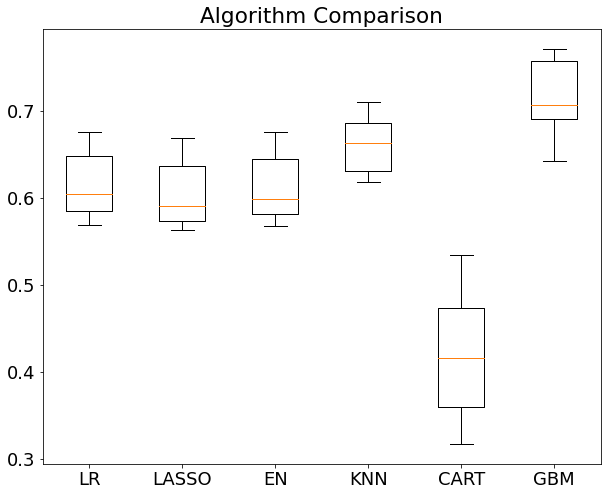

In [377]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [438]:
##Tuning for hyperparams
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
'max_depth': [4, 6],
'min_samples_leaf': [3, 5, 9, 17],
'max_features': [1.0, 0.3, 0.1] ## not possible in our example (only 1 fx)
}

est = GradientBoostingRegressor(n_estimators=4000)

gs_cv = GridSearchCV(est, param_grid, n_jobs=4).fit(X_train[0], y_train[0])

gs_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'max_features': 0.3,
 'min_samples_leaf': 17}

In [433]:
model = GradientBoostingRegressor(n_estimators=4000, learning_rate= 0.01, max_depth= 4, max_features= 0.3, min_samples_leaf= 17)
results = []
for i in range(len(X_test)):
    model.fit(X_train[i], y_train[i])
    y_pred = model.predict(X_test[i])
    results.append(pd.DataFrame({'actual': y_test[i],
                                'prediction': y_pred})
                  .sort_values('prediction', ascending=False).reset_index())

In [434]:
joined_results = pd.concat(results, axis = 1)

In [435]:
top3 = joined_results['season_player'].head(3)
top3.columns = years

In [430]:
def color_winners(val):
    color = 'red' if val in winners else 'black'
    return 'color: %s' % color

In [431]:
winners = ['2003Buckley, Nathan', '2003Ricciuto, Mark', '2003Goodes, Adam',
          '2004Judd, Chris',
          '2005Cousins, Ben',
          '2006Goodes, Adam',
          '2007Bartel, Jimmy',
          '2008Cooney, Adam',
          '2009Ablett, Gary',
          '2010Judd, Chris',
          '2011Swan, Dane',
          '2012Watson, Jobe',
          '2013Ablett, Gary',
          '2014Priddis, Matt',
          '2015Fyfe, Nat',
          '2016Dangerfield, Patrick',
          '2017Martin, Dustin',
          '2018Mitchell, Tom',
          '2019Fyfe, Nat']

In [436]:
top3.head(3).style.applymap(color_winners)

,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,"2003Buckley, Nathan","2004Ricciuto, Mark","2005Judd, Chris","2006Judd, Chris","2007Ablett, Gary","2008Ablett, Gary","2009Ablett, Gary","2010Ablett, Gary","2011Swan, Dane","2012Ablett, Gary","2013Ablett, Gary","2014Dangerfield, Patrick","2015Gray, Robbie","2016Dangerfield, Patrick","2017Martin, Dustin","2018Dangerfield, Patrick","2019Kelly, Tim"
1,"2003Black, Simon","2004Brown, Nathan","2005Cousins, Ben","2006Goodwin, Simon","2007Corey, Joel","2008Cooney, Adam","2009Swan, Dane","2010Montagna, Leigh","2011Murphy, Marc","2012Cotchin, Trent","2013Swan, Dane","2014Selwood, Joel","2015Dangerfield, Patrick","2016Treloar, Adam","2017Dangerfield, Patrick","2018Cripps, Patrick","2019Prestia, Dion"
2,"2003Cousins, Ben","2004Tredrea, Warren","2005Hodge, Luke","2006Hall, Barry","2007Pavlich, Matthew","2008Mitchell, Sam","2009Boyd, Matthew","2010Swan, Dane","2011Mitchell, Sam","2012Dangerfield, Patrick","2013Kennedy, Josh P","2014Gray, Robbie","2015Fyfe, Nat","2016Kennedy, Josh P","2017Mitchell, Tom","2018Mitchell, Tom","2019Martin, Dustin"


In [397]:
score = 0
for w in winners:
    if w in top3.values:
        score += 1
        
print('Actual winner was predicted in top-3 best players ' + str(score) + ' time out of possible 17')

Actual winner was predicted in top-3 best players 11 time out of possible 17


Disposals, Score: 0.11858312245953152
Kicks, Score: 0.0990927237530512
Marks, Score: 0.015461589037327741
Handballs, Score: 0.043423974319076165
Hitouts, Score: 0.009676815935292847
Goals, Score: 0.043273430264845744
Behinds, Score: 0.015798249841636056
Tackles, Score: 0.013873073889417945
Rebound50s, Score: 0.006451363660773456
Inside50s, Score: 0.09581917109834594
Clearances, Score: 0.14552583417495926
Clangers, Score: 0.017654623779345683
FreesFor, Score: 0.01650771197848688
FreesAgainst, Score: 0.004307017869751664
ContendedPossessions, Score: 0.23686246750502882
UncontendedPossessions, Score: 0.016993086088918384
ContestedMarks, Score: 0.01676084155098485
MarksInside50, Score: 0.01842433573799147
OnePercenters, Score: 0.009030648478231908
Bounces, Score: 0.011106287752591877
GoalAssists, Score: 0.024317818789420905
PercentPlayed, Score: 0.021055812034989848


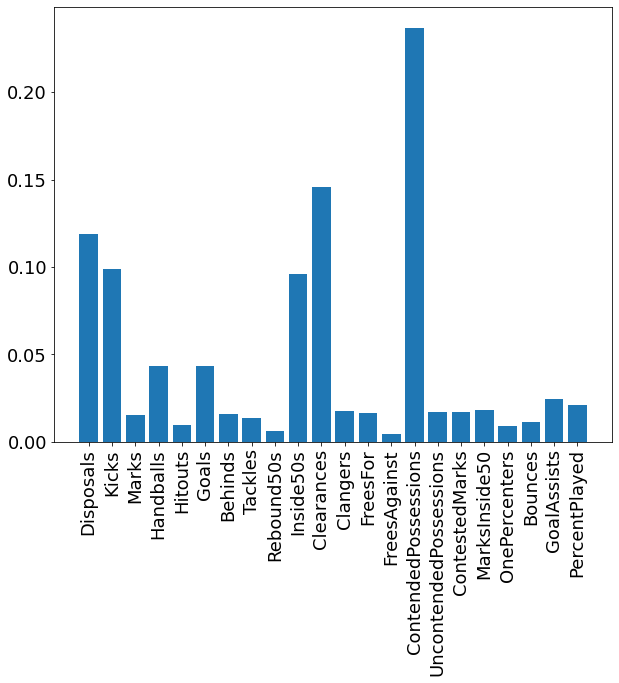

In [393]:
importance = model.feature_importances_
for i,v in enumerate(importance):
    print('{}, Score: {}'.format(X_test[0].columns[i],v))

bars = X_test[0].columns
y_pos = range(len(bars))
pyplot.bar(X_test[0].columns, importance)
pyplot.xticks(y_pos, bars, rotation=90)
pyplot.show()